# Manual Tuning Adjacency Matrix

In [1]:
# single nn underestimating influence of key drivers (in terms of absolute values)

# would be great if it was not underestimating the impact of local drivers

# range, mean, confidence intervall, 95%

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [4]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
import pickle
import itertools
import time
import datetime
import glob
import numpy as np
import gc

## Save causal matrix

In [7]:
def get_setup(setup_file):
    setup = SetupDiagnostics(["-c", setup_file])
    return setup

In [8]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [9]:
def get_input_layer_weights(model):
    input_layer_weights = [model.input_sub_layers[0].trainable_variables[0]]
    input_layer_weights.extend([layer.trainable_variables[0] * layer.mask for layer in model.input_sub_layers[1:]])
    
    return input_layer_weights

In [10]:
def save_causal_matrix(cm, output_dir, name="causal_matrix.npy"):
    write_file = os.path.join(output_dir, name)
    with open(write_file, 'wb') as f:
        np.save(f, cm)
    
    print(f"\nSaved causal matrix {Path(*Path(write_file).parts[-4:])}.")


In [11]:
def load_causal_matrix(output_dir, name="causal_matrix.npy"):
    read_file = os.path.join(output_dir, name)
    print(f"\nLoading causal matrix {Path(*Path(read_file).parts[-4:])}.")
    with open(read_file, 'rb') as f:
        cm = np.load(f)
    return cm

In [33]:
def save_causal_matrix_for_tuning_model(model_tuned, v_name):
    t_init_total = time.time()
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)
    
    for p, s in itertools.product(lambda_prediction, lambda_sparsity):
        params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

        cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
        output_dir = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "causal_matrices")
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Saving causal matrix for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}")
        t_init = time.time()
        
        setup = get_setup(cfg)
        model_inputs = load_single_model(setup, v_name)
        
        model = model_inputs[var][0]
        
        input_layer_weights = get_input_layer_weights(model)
        causal_matrix = model.compute_l2_norm_matrix(input_layer_weights).numpy()
        
        # Save with numpy.save
        save_causal_matrix(causal_matrix, output_dir)
        
        t_end = datetime.timedelta(seconds=time.time() - t_init)
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Finished for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}. Elapsed time: {t_end}")
        
        del model_inputs
        gc.collect()
        
    t_end_total = datetime.timedelta(seconds=time.time() - t_init_total)
    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"--- Finished saving causal matrices for {model_tuned}. Total elapsed time: {t_end_total}\n\n")

> **Note:** These are parameters for saving and thresholding the causal matrix.  
> Parameters for plotting are set below. 

In [13]:
# Set tuning parameters
lambda_prediction =[1, 5, 10, 100, 1000] #[1, 2, 4, 8, 10]
lambda_sparsity = [1.0] #[0.1, 0.5, 1.0]

var_name = "tphystnd-820.86" # tphystnd-691.39, tphystnd-820.86

# Set base directory for config files and inputs/outputs list files

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_entry_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_entry_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_matrix_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_matrix_scaled_init_he

PROJECT_ROOT = Path.cwd().parent.resolve()
base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v5-transposed_l1_entry_scaled_init_he") # "manual_tuning_tphystnd_691.39_v3-test2", "-transposed_l1"
outputs_map_path = os.path.join(base_dir, "outputs_map.txt")
tuning_models = ["castle_adapted_big_notears"] 
                 # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"


In [14]:
tunings = [("manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled", "tphystnd-691.39"),
           ("manual_tuning_tphystnd_820.86_v4-transposed_l1_entry_scaled", "tphystnd-820.86")]

for tuning_dir, v in tunings:
    base_dir = os.path.join(PROJECT_ROOT, "output_castle", tuning_dir) 
    var_name = v
    
    t_start = time.time()
    
    print(f"\nBase directory: {base_dir}")
    for m in tuning_models:
        save_causal_matrix_for_tuning_model(m, var_name)

    t_finish =  datetime.timedelta(seconds=time.time() - t_start)

    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"------ Finished. Total elapsed time: {t_finish}\n\n")


Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled


2023-12-06 06:50:27 --- Saving causal matrix for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0

Load model: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled/castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/models/CASTLEAdapted/r1.0-a1.0-lpred1.0-lspar1.0-lrec1.0-lacy1.0-NOTEARS-mirrored/hl_256_256_256_256_256_256_256_256_256-act_ReLU-e_18/1_20_model.keras

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix.npy.

2023-12-06 06:50:43 --- Finished for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0. Elapsed time: 0:00:16.433666


2023-12-06 06:50:43 --- Saving causal matrix fo

In [72]:
print(f"\nBase directory: {base_dir}")

t_start = time.time()
for m in tuning_models:
    save_causal_matrix_for_tuning_model(m, var_name)

t_finish =  datetime.timedelta(seconds=time.time() - t_start)

print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
      f"------ Finished. Total elapsed time: {t_finish}\n\n")


Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he


2023-11-29 15:17:52 --- Saving causal matrix for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0

Load model: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he/castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/models/CASTLEAdapted/r1.0-a1.0-lpred1.0-lspar1.0-lrec1.0-lacy1.0-NOTEARS-mirrored/hl_256_256_256_256_256_256_256_256_256-act_ReLU-e_18/1_22_model.keras

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix.npy.

2023-11-29 15:18:06 --- Finished for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0. Elapsed time: 0:00:13.937366


2023-11-29 15:18:06 --- Saving 

## Threshold 

In [15]:
def threshold_causal_matrix(cm, threshold):
    return (cm > threshold) * cm

In [16]:
def threshold_causal_matrix_for_tuning_model(model_tuned, v_name, threshold):
    t_init_total = time.time()
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)
    
    for p, s in itertools.product(lambda_prediction, lambda_sparsity):
        params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

        output_dir = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "causal_matrices")
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Thresholding causal matrix for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}")
        t_init = time.time()
        
        causal_matrix = load_causal_matrix(output_dir, name="causal_matrix.npy")
        if isinstance(threshold, list):
            for t in threshold:
                cm_t = threshold_causal_matrix(causal_matrix, t)
                save_causal_matrix(cm_t, output_dir, name=f"causal_matrix_threshold-{t}.npy")
        else:
            cm_t = threshold_causal_matrix(causal_matrix, threshold)
            save_causal_matrix(cm_t, output_dir, name=f"causal_matrix_threshold-{t}.npy")
            
        # Threshold mean
        mean = causal_matrix.mean()
        cm_t = threshold_causal_matrix(causal_matrix, mean)
        save_causal_matrix(cm_t, output_dir, name="causal_matrix_threshold-mean-{:.6f}.npy".format(mean))
       
        
        t_end = datetime.timedelta(seconds=time.time() - t_init)
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Finished for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}. Elapsed time: {t_end}")
        
    t_end_total = datetime.timedelta(seconds=time.time() - t_init_total)
    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"--- Finished thresholding causal matrices for {model_tuned}. Total elapsed time: {t_end_total}\n\n")

In [17]:
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
thresholds = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [18]:
tunings = [("manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled", "tphystnd-691.39"),
           ("manual_tuning_tphystnd_820.86_v4-transposed_l1_entry_scaled", "tphystnd-820.86")]

for idx, (tuning_dir, v) in enumerate(tunings):
    base_dir = os.path.join(PROJECT_ROOT, "output_castle", tuning_dir) 
    var_name = v
    
    t_start = time.time()
    
    print(f"\n\nBase directory: {base_dir}")
    for m in tuning_models:
        threshold_causal_matrix_for_tuning_model(m, var_name, thresholds)

    t_finish =  datetime.timedelta(seconds=time.time() - t_start)

    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"------ Finished {idx}. Total elapsed time: {t_finish}\n\n")



Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled


2023-12-06 06:53:49 --- Thresholding causal matrix for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0

Loading causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.0001.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.001.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.002.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.003.npy.

Saved causal matrix castle_adapted_b

In [19]:
# Set tuning parameters
lambda_prediction =[1, 5, 10, 100, 1000] #[1, 2, 4, 8, 10]
lambda_sparsity = [1.0] #[0.1, 0.5, 1.0]

var_name = "tphystnd-820.86" # tphystnd-691.39, tphystnd-820.86

# Set base directory for config files and inputs/outputs list files

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_entry_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_entry_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_matrix_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_matrix_scaled_init_he

PROJECT_ROOT = Path.cwd().parent.resolve()
base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v3-transposed_l1_entry_scaled") # "manual_tuning_tphystnd_691.39_v3-test2", "-transposed_l1"
outputs_map_path = os.path.join(base_dir, "outputs_map.txt")
tuning_models = ["castle_adapted_big_notears"] 
                 # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"


In [20]:
print(f"\nBase directory: {base_dir}")

t_start = time.time()
for m in tuning_models:
    threshold_causal_matrix_for_tuning_model(m, var_name, thresholds)

t_finish =  datetime.timedelta(seconds=time.time() - t_start)

print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
      f"------ Finished. Total elapsed time: {t_finish}\n\n")


Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled


2023-12-06 06:53:51 --- Thresholding causal matrix for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0

Loading causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.0001.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.001.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.002.npy.

Saved causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.003.npy.

Saved causal matrix castle_adapted_bi

## Plot causal input features

In [21]:
import matplotlib.pyplot as plt
import cmocean


In [22]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)


In [23]:
def get_input_idx2_var(setup, input_idx):
    input_vars = generate_input_vars(setup)
    input_idx2var = {}
    for i in input_idx: 
        input_idx2var[i] = input_vars[i]
    return input_idx2var

In [24]:
def get_tuned_causal_inputs_per_threshold(t, save_dir, tuned_nn_input_idx):
    if t == "mean":
        name = Path(glob.glob(os.path.join(save_dir, "causal_matrix_threshold-mean*.npy"))[0]).name
    else: 
        name = f"causal_matrix_threshold-{t}.npy"
    cm_t = load_causal_matrix(save_dir, name=name)
    tuned_causal_inputs = tuned_nn_input_idx[(cm_t[:, 0] > 0)[1:]]
    
    return tuned_causal_inputs

In [25]:
def plot_causal_inputs_per_threshold(causal_nn_inputs, single_nn_inputs, tuned_nn_inputs, v_name, input_vars, thresholds, save_dir, p, s, save=False): 
    plt.rcParams['text.usetex'] = True

    fig, ax = plt.subplots()
    fig.set_figwidth(15)

    cmap = cmocean.cm.thermal
    rescale = lambda  y: (y - np.min(y)) / (np.max(y) - np.min(y))
    colors = cmap(rescale(range(5))) 

    # plot SingleNN
    ax.scatter(single_nn_inputs, [1] * len(single_nn_inputs),
        marker='o', #s=20**2, 
        color=colors[-2])

    # plot CausalSingleNN
    ax.scatter(causal_nn_inputs, [2] * len(causal_nn_inputs),
        marker='o', #s=20**2, 
        color=colors[-3])

    y_labels = ["", "SingleNN", "CausalSingleNN"]

    for idx, t in enumerate(thresholds):
        tuned_causal_inputs_for_t = get_tuned_causal_inputs_per_threshold(t, save_dir, np.array(tuned_nn_inputs))

        ax.scatter(tuned_causal_inputs_for_t, [idx + 3] * len(tuned_causal_inputs_for_t), 
                   marker='o', #s=20**2, 
                   color=colors[-4])

        y_labels.append(f"CASTLE $\lambda_p={p}$, $\lambda_s={s}$, t={t}")


    ax.set_xticks(range(len(input_vars)))
    ax.set_xticklabels(input_vars, rotation=90, ha='center', va='top')


    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, rotation=0, ha='right', va='center')


    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_axisbelow(True)
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)


    ax.set_xlabel('Input Features', labelpad=15, color='#333333')
    ax.set_title(f'Causal Input Features per Threshold for Variable {v_name}', pad=15, color='#333333', weight='bold', fontsize=15)

    fig.tight_layout()

    if save: 
        output_dir = os.path.join(save_dir, "plots")
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        name = f"causal_input_features_per_threshold_{v_name}.png"

        plt.savefig(os.path.join(save_dir, name), dpi=200)
        print(f'\nSaving causal matrix plot {name}.')
        plt.close()


In [26]:
def sanity_check(num_inputs, causal_input2idx, single_input2idx, tuned_input2idx):
    for i in range(num_inputs):
        if i in causal_input2idx.keys():
            assert tuned_input2idx[i] == causal_input2idx[i]
        assert tuned_input2idx[i] == single_input2idx[i]

In [27]:
def plot_causal_input_features_for_tuning_model(model_tuned, v_name, threshold):
    t_init_total = time.time()
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)
    
    single_nn_setup = get_setup(single_nn_config)
    single_nn = load_single_model(single_nn_setup, v_name)
    single_nn_input_idx = single_nn[var][1]
    
    causal_nn_setup = get_setup(causal_nn_config)
    causal_nn = load_single_model(causal_nn_setup, v_name)
    causal_nn_input_idx = causal_nn[causal_nn_setup.pc_alphas[0]][causal_nn_setup.thresholds[0]][var][1]

    causal_nn_input_idx2var = get_input_idx2_var(causal_nn_setup, causal_nn_input_idx)
    single_nn_input_idx2var = get_input_idx2_var(single_nn_setup, single_nn_input_idx)
    
    for p, s in itertools.product(lambda_prediction, lambda_sparsity):
        params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"
        
        matrices_dir = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "causal_matrices")
        
        # Get model inputs
        cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
        setup = get_setup(cfg)
        model_and_inputs = load_single_model(setup, var_name)
        tuned_nn_inputs = model_and_inputs[Variable_Lev_Metadata.parse_var_name(v_name)][1]
        
        # Do sanity check
        tuned_nn_input_idx2var = get_input_idx2_var(setup, tuned_nn_inputs)
        sanity_check(len(single_nn_input_idx), causal_nn_input_idx2var, single_nn_input_idx2var, tuned_nn_input_idx2var)
        
        print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Plotting causal input features for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}")
        t_init = time.time()
                
        if not isinstance(threshold, list):
            threshold = [threshold]
            
        input_variables = [str(v) for v in generate_input_vars(single_nn_setup)]
        # Plot
        plot_causal_inputs_per_threshold(causal_nn_input_idx, single_nn_input_idx, tuned_nn_inputs, 
                                         v_name, input_variables, threshold, matrices_dir, p=p, s=s, save=True)
  
        t_end = datetime.timedelta(seconds=time.time() - t_init)
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Finished for model {model_tuned} with parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}. Elapsed time: {t_end}")
        
    t_end_total = datetime.timedelta(seconds=time.time() - t_init_total)
    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"--- Finished plotting causal input features for {model_tuned}. Total elapsed time: {t_end_total}\n\n")

In [28]:
causal_nn_config = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/cfg_causal_single_nn_diagnostics.yml")
single_nn_config = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/single_nn/cfg_single_nn_diagnostics.yml")

In [29]:
var_name = "tphystnd-820.86" # tphystnd-820.86, tphystnd-691.39

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_entry_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_entry_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_matrix_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_matrix_scaled_init_he


PROJECT_ROOT = Path.cwd().parent.resolve()
base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v5-transposed_l1_entry_scaled_init_he") # "manual_tuning_tphystnd_691.39_v3-test2", -transposed_l1
outputs_map_path = os.path.join(base_dir, "outputs_map.txt")
tuning_models = ["castle_adapted_big_notears"] 
                 # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"

var = Variable_Lev_Metadata.parse_var_name(var_name)

In [30]:
# thresholds = [0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
thresholds = ["mean", 0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [31]:
tunings = [("manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled", "tphystnd-691.39"),
           ("manual_tuning_tphystnd_820.86_v4-transposed_l1_entry_scaled", "tphystnd-820.86")]

for idx, (tuning_dir, v) in enumerate(tunings):
    base_dir = os.path.join(PROJECT_ROOT, "output_castle", tuning_dir) 
    var_name = v
    
    t_start = time.time()
    
    print(f"\n\nBase directory: {base_dir}")
    for m in tuning_models:
        plot_causal_input_features_for_tuning_model(m, var_name, thresholds)
        
    t_finish =  datetime.timedelta(seconds=time.time() - t_start)

    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"------ Finished {idx}. Total elapsed time: {t_finish}\n\n")



Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled

Load model: /work/bd1179/b309172/analysis/usmile/causality_convection/python/causalnncam/models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_20_model.h5

Load model: /work/bd1179/b309172/analysis/usmile/causality_convection/python/causalnncam/models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_20_model.h5

Load model: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled/castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/models/CASTLEAdapted/r1.0-a1.0-lpred1.0-lspar1.0-lrec1.0-lacy1.0-NOTEARS-mirrored/hl_256_256_256_256_256_256_256_256_256-act_ReLU-e_18/1_20_model.keras


2023-12-06 06:54:22 --- Plo

In [87]:
print(f"\nBase directory: {base_dir}")

t_start = time.time()
for m in tuning_models:
    plot_causal_input_features_for_tuning_model(m, var_name, thresholds)

t_finish =  datetime.timedelta(seconds=time.time() - t_start)

print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
      f"------ Finished. Total elapsed time: {t_finish}\n\n")


Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he

Load model: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he/castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/models/CASTLEAdapted/r1.0-a1.0-lpred1.0-lspar1.0-lrec1.0-lacy1.0-NOTEARS-mirrored/hl_256_256_256_256_256_256_256_256_256-act_ReLU-e_18/1_22_model.keras


2023-11-29 15:19:19 --- Plotting causal input features for model castle_adapted_big_notears with parameters lambda_prediciton=1, lambda_sparsity=1.0

Loading causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.2.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.3.npy.

Loading causal matrix castle_ad

## Single Plot

In [93]:
var_name = "tphystnd-820.86" # tphystnd-820.86, tphystnd-691.39

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_entry_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_entry_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he

# manual_tuning_tphystnd_691.39_v3-test2-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_691.39_v5-transposed_l1_matrix_scaled_init_he
# manual_tuning_tphystnd_820.86_v3-transposed_l1_matrix_scaled
# manual_tuning_tphystnd_820.86_v5-transposed_l1_matrix_scaled_init_he


PROJECT_ROOT = Path.cwd().parent.resolve()
base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v3-transposed_l1_entry_scaled") # "manual_tuning_tphystnd_691.39_v3-test2", -transposed_l1
outputs_map_path = os.path.join(base_dir, "outputs_map.txt")
tuning_models = ["castle_adapted_big_notears"] 
                 # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"

var = Variable_Lev_Metadata.parse_var_name(var_name)

In [94]:
p = 1000
s = 1.0
model_tuned = "castle_adapted_big_notears"

In [95]:
causal_nn_setup = get_setup(causal_nn_config)
causal_nn = load_single_model(causal_nn_setup, var_name)
causal_nn_input_idx = causal_nn[causal_nn_setup.pc_alphas[0]][causal_nn_setup.thresholds[0]][var][1]


Load model: /work/bd1179/b309172/analysis/usmile/causality_convection/python/causalnncam/models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_22_model.h5


In [96]:
single_nn_setup = get_setup(single_nn_config)
single_nn = load_single_model(single_nn_setup, var_name)
single_nn_input_idx = single_nn[var][1]


Load model: /work/bd1179/b309172/analysis/usmile/causality_convection/python/causalnncam/models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_22_model.h5


In [97]:
causal_nn_input_idx2var = get_input_idx2_var(causal_nn_setup, causal_nn_input_idx)
single_nn_input_idx2var = get_input_idx2_var(single_nn_setup, single_nn_input_idx)

In [98]:
params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
output_dir = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "causal_matrices")

setup = get_setup(cfg)
model_inputs = load_single_model(setup, var_name)


Load model: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v3-transposed_l1_entry_scaled/castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/models/CASTLEAdapted/r1.0-a1.0-lpred1000.0-lspar1.0-lrec1.0-lacy1.0-NOTEARS-mirrored/hl_256_256_256_256_256_256_256_256_256-act_ReLU-e_18/1_22_model.keras


In [99]:
tuned_nn_input_idx = np.array(model_inputs[var][1])
tuned_nn_input_vars =  generate_input_vars(setup)

In [100]:
tuned_nn_input_idx2var = get_input_idx2_var(setup, tuned_nn_input_idx)

In [101]:
sanity_check(len(single_nn_input_idx), causal_nn_input_idx2var, single_nn_input_idx2var, tuned_nn_input_idx2var)

In [102]:
input_variables = [str(v) for v in tuned_nn_input_vars]

In [103]:
output_dir = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "causal_matrices")
Path(output_dir).mkdir(parents=True, exist_ok=True)

cm = load_causal_matrix(output_dir, name="causal_matrix.npy")



Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix.npy.


In [104]:
cm.mean()

4.1577747e-05

In [105]:
t = 0.002

In [106]:
m_t = threshold_causal_matrix(cm, t)

In [107]:
m_t.min()

0.0

In [108]:
m_t.max()

0.015620239

In [109]:
(m_t[:, 0] > 0).sum()

41

In [110]:
(m_t > 0).sum()

51

In [89]:
thresholds = ["mean", 0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]


Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-mean-0.000042.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.001.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.002.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.003.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.004.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.005.npy.

Loading causal matrix castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/causal_matrices/causal_matrix_threshold-0.01.npy.


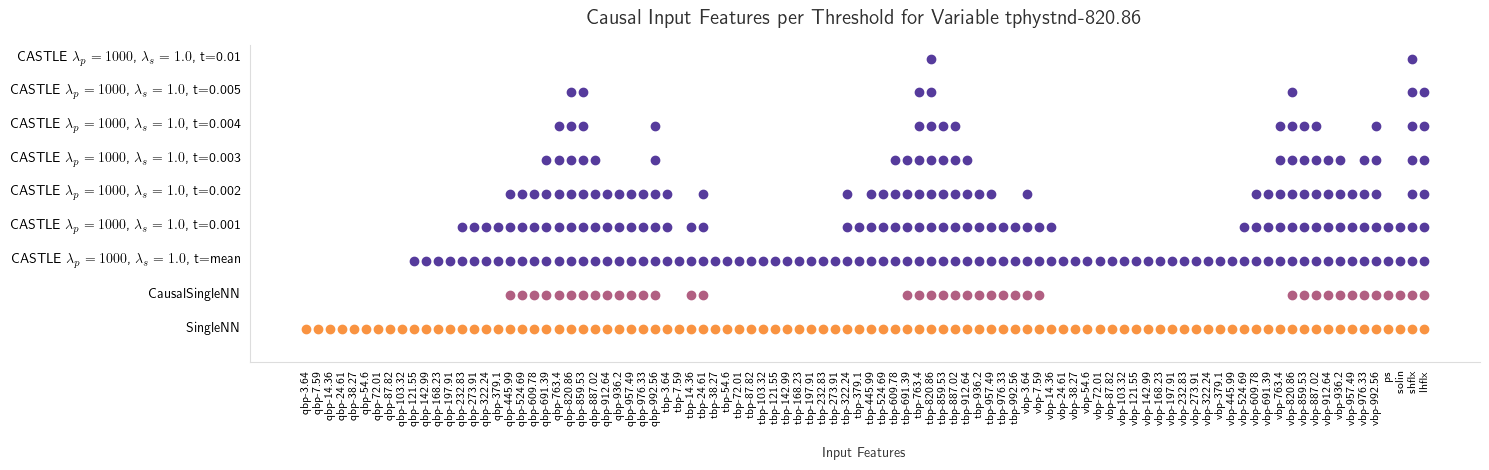

In [88]:
plot_causal_inputs_per_threshold(causal_nn_input_idx, single_nn_input_idx, tuned_nn_input_idx, var_name, input_variables, thresholds, output_dir, p=p, s=s)


In [45]:
# z values for two sided confidence interval (Machine Learning, Tom M. Mitchell, p. 132)
# Assumes normal distribution
confidence2z_value = {50: 0.67, 68: 1.00, 80: 1.28, 90:1.64, 95: 1.96, 98: 2.33, 99: 2.58}


# Two sided confidence interval [L, U] 100(1-alpha)%  -> 95 percent --> alpha=5
# One sided confidence interval [L, inf) implies confidence 100(1-alpha/2)%

# 

**Convert two-sided confidence interval into one-sided confidence interval:**  
Because of the symmetry of the normal distribution, a two-sided confidence interval with confidence $100(1-\alpha)\%$ with lower bound $L$ and upper bound $U$,  
implies a one-sided confidence interval with confidence $100(1-\alpha)\%$ and lower bound $L$ or upper bound $U$.  

Examples: 
Two-sided confidence interval $[L, U]$ with confidence $90\% = 100(1-10)\%$, implies one-sided confidence intervall $[L, \infty)$ with $95\% = 100(1-5)\%$.